In [1]:
from WBT.whitebox_tools import WhiteboxTools
import rasterio
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import math
import time

wbt = WhiteboxTools()

In [2]:
os.chdir(r'C:\\Users\\sasha\\abstract_surfaces\\')

In [3]:
entries = os.listdir('./surfaces/')
entries

['best',
 'clear',
 'current_hemicylinder.tif',
 'current_hemisphere.tif',
 'current_inclined.tif',
 'current_paraboloid.tif',
 'filtered',
 'morpho',
 'noisy',
 'res.png',
 'results.txt']

In [5]:
clear_dems = os.listdir('./surfaces/' + entries[1])
noisy_dems = os.listdir('./surfaces/' + entries[-3])

print(f'Clear dems: {clear_dems}', f'Noisy dems: {noisy_dems}', sep='\n\n')

Clear dems: ['hemicylinder_clear.tif', 'hemisphere_clear.tif', 'inclined_clear.tif', 'paraboloid_clear.tif']

Noisy dems: ['hemicylinder_n_05.tif', 'hemicylinder_n_1.tif', 'hemicylinder_n_2.tif', 'hemicylinder_un_05.tif', 'hemicylinder_un_1.tif', 'hemicylinder_un_2.tif', 'hemisphere_n_05.tif', 'hemisphere_n_1.tif', 'hemisphere_n_2.tif', 'hemisphere_un_05.tif', 'hemisphere_un_1.tif', 'hemisphere_un_2.tif', 'inclined_n_05.tif', 'inclined_n_1.tif', 'inclined_n_2.tif', 'inclined_un_05.tif', 'inclined_un_1.tif', 'inclined_un_2.tif', 'paraboloid_n_05.tif', 'paraboloid_n_1.tif', 'paraboloid_n_2.tif', 'paraboloid_un_05.tif', 'paraboloid_un_1.tif', 'paraboloid_un_2.tif']


In [6]:
arr_clear_dems = []
for clear_dem in clear_dems:
    
    tmp_path = r'C:\Users\sasha\abstract_surfaces\surfaces\clear\\' + clear_dem
    #print(tmp_path)
    
    with rasterio.open(tmp_path, 'r') as ds:
        arr_in = ds.read()
    #arr_clear_dems[clear_dem] = arr_in[0]
    arr_clear_dems.append(arr_in[0])
    #plt.imshow(arr_noisy_dems[-1], cmap='binary')
    #plt.show()
    print(f'Appended {clear_dem}')

Appended hemicylinder_clear.tif
Appended hemisphere_clear.tif
Appended inclined_clear.tif
Appended paraboloid_clear.tif


In [7]:
arr_noisy_dems = []
for noisy_dem in noisy_dems:
    
    tmp_path = r'C:\Users\sasha\abstract_surfaces\surfaces\noisy\\' + noisy_dem
    #print(tmp_path)
    
    with rasterio.open(tmp_path, 'r') as ds:
        arr_in = ds.read()
    #arr_noisy_dems[noisy_dem] = arr_in[0]
    arr_noisy_dems.append(arr_in[0])
    #plt.imshow(arr_noisy_dems[-1], cmap='binary')
    #plt.show()
    print(f'Appended {noisy_dem}')

Appended hemicylinder_n_05.tif
Appended hemicylinder_n_1.tif
Appended hemicylinder_n_2.tif
Appended hemicylinder_un_05.tif
Appended hemicylinder_un_1.tif
Appended hemicylinder_un_2.tif
Appended hemisphere_n_05.tif
Appended hemisphere_n_1.tif
Appended hemisphere_n_2.tif
Appended hemisphere_un_05.tif
Appended hemisphere_un_1.tif
Appended hemisphere_un_2.tif
Appended inclined_n_05.tif
Appended inclined_n_1.tif
Appended inclined_n_2.tif
Appended inclined_un_05.tif
Appended inclined_un_1.tif
Appended inclined_un_2.tif
Appended paraboloid_n_05.tif
Appended paraboloid_n_1.tif
Appended paraboloid_n_2.tif
Appended paraboloid_un_05.tif
Appended paraboloid_un_1.tif
Appended paraboloid_un_2.tif


In [8]:
best_path = r'C:\Users\sasha\abstract_surfaces\surfaces\best\best_' + noisy_dems[15]

print(best_path)

cur = r'C:\Users\sasha\abstract_surfaces\surfaces\current_' + noisy_dems[15].split('_')[0] + '.tif'

shutil.copy2(cur, best_path)
# shutil.move(new, best_path)

C:\Users\sasha\abstract_surfaces\surfaces\best\best_inclined_un_05.tif


'C:\\Users\\sasha\\abstract_surfaces\\surfaces\\best\\best_inclined_un_05.tif'

In [21]:
arr_filtered_dems = []
best_filter = {}

start_time = time.time()

with open(r'C:\Users\sasha\abstract_surfaces\surfaces\results.txt', 'w+') as file:
    
    file.write('\n')
    
    for noisy_dem in noisy_dems:
        
        file.write('---\n' + noisy_dem + '\n')
        
        clear_path = r'C:\Users\sasha\abstract_surfaces\surfaces\clear\\' + noisy_dem.split('_')[0] + '_clear.tif'
        tmp_path = r'C:\Users\sasha\abstract_surfaces\surfaces\noisy\\' + noisy_dem
        output_path = r'C:\Users\sasha\abstract_surfaces\surfaces\current_' + noisy_dem.split('_')[0] + '.tif'
        best_path = r'C:\Users\sasha\abstract_surfaces\surfaces\best\best_' + noisy_dem
        #good_path = r'C:\Users\sasha\abstract_surfaces\surfaces\best_' + noisy_dem.split('_')[0] + '.tif'

        with rasterio.open(clear_path, 'r') as ds:
            data_clear = ds.read()
            data_clear = data_clear[0] 

        with rasterio.open(tmp_path, 'r') as ds:
            data_noisy = ds.read()
            data_noisy = data_noisy[0]    

        min_mean = 99999

        wbt.verbose = False

        # - - -
        #MeanFilter
        for filt_xy in range(3, 16, 2):
            wbt.mean_filter(
                i = tmp_path, 
                output = output_path, 
                filterx=filt_xy, 
                filtery=filt_xy
            )

            with rasterio.open(output_path, 'r') as ds:
                data_filt = ds.read()
                data_filt = data_filt[0]

            if abs(np.mean(np.subtract(data_clear, data_filt))) < min_mean:
                best_filter.update({noisy_dem : ['MeanFilter', filt_xy, filt_xy]})
                min_mean = abs(np.mean(np.subtract(data_clear, data_filt)))
                # shutil.copy2(src=output_path, dst=best_path)

            file.write('\t' + f'MeanFilter: {filt_xy} * {filt_xy}. ' + \
                       f'mean = {abs(np.mean(np.subtract(data_clear, data_filt)))}' + '\n')

        # - - -
        #MedianFilter
            wbt.median_filter(
                i = tmp_path, 
                output = output_path, 
                filterx=filt_xy, 
                filtery=filt_xy,
                sig_digits=2
            )

            with rasterio.open(output_path, 'r') as ds:
                data_filt = ds.read()
                data_filt = data_filt[0]

            if abs(np.mean(np.subtract(data_clear, data_filt))) < min_mean:
                best_filter.update({noisy_dem : ['MedianFilter', filt_xy, filt_xy]})
                min_mean = abs(np.mean(np.subtract(data_clear, data_filt)))
                # shutil.copy(src=output_path, dst=best_path)

            file.write('\t' + f'MedianFilter: {filt_xy} * {filt_xy}. ' + \
                       f'mean = {abs(np.mean(np.subtract(data_clear, data_filt)))}' + '\n')
            
        #ConservativeSmoothingFilter

            wbt.conservative_smoothing_filter(
                i = tmp_path,
                output = output_path,
                filterx=filt_xy, 
                filtery=filt_xy
            )

            with rasterio.open(output_path, 'r') as ds:
                data_filt = ds.read()
                data_filt = data_filt[0]

            if abs(np.mean(np.subtract(data_clear, data_filt))) < min_mean:
                best_filter.update({noisy_dem : ['ConservativeSmoothingFilter', filt_xy, filt_xy]})
                min_mean = abs(np.mean(np.subtract(data_clear, data_filt)))
                # shutil.copy(src=output_path, dst=best_path)

            file.write('\t' + f'ConservativeSmoothingFilter: {filt_xy} * {filt_xy}. ' + \
                       f'mean = {abs(np.mean(np.subtract(data_clear, data_filt)))}' + '\n')

        # - - -
        #AdaptiveFilter & EdgePresevingFilter
            for threshold in np.arange(0.1, 2.1, 0.1):
                threshold = round(threshold, 2)
                wbt.adaptive_filter(
                    i = tmp_path, 
                    output = output_path, 
                    filterx=filt_xy, 
                    filtery=filt_xy, 
                    threshold=threshold
                )

                with rasterio.open(output_path, 'r') as ds:
                    data_filt = ds.read()
                    data_filt = data_filt[0]

                if abs(np.mean(np.subtract(data_clear, data_filt))) < min_mean:
                    best_filter.update({noisy_dem : ['AdaptiveFilter', filt_xy, filt_xy, threshold]})
                    min_mean = abs(np.mean(np.subtract(data_clear, data_filt)))
                    # shutil.copy(src=output_path, dst=best_path)

                file.write('\t' + f'AdaptiveFilter: {filt_xy} * {filt_xy}, {threshold}. ' + \
                       f'mean = {abs(np.mean(np.subtract(data_clear, data_filt)))}' + '\n')
                                
                wbt.edge_preserving_mean_filter(
                    i = tmp_path, 
                    output = output_path, 
                    filter=filt_xy,
                    threshold=threshold
                )

                with rasterio.open(output_path, 'r') as ds:
                    data_filt = ds.read()
                    data_filt = data_filt[0]

                if abs(np.mean(np.subtract(data_clear, data_filt))) < min_mean:
                    best_filter.update({noisy_dem : ['EdgePreservingFilter', filt_xy, filt_xy, threshold]})
                    min_mean = abs(np.mean(np.subtract(data_clear, data_filt)))
                    # shutil.copy2(src=output_path, dst=best_path)

                file.write('\t' + f'EdgePresevingFilter: {filt_xy} * {filt_xy}, {threshold}. ' + \
                       f'mean = {abs(np.mean(np.subtract(data_clear, data_filt)))}' + '\n')

        # - - -
        #OlympicFilter
            wbt.olympic_filter(
                i=tmp_path, 
                output=output_path, 
                filterx=filt_xy, 
                filtery=filt_xy
            )

            with rasterio.open(output_path, 'r') as ds:
                data_filt = ds.read()
                data_filt = data_filt[0]

            if abs(np.mean(np.subtract(data_clear, data_filt))) < min_mean:
                best_filter.update({noisy_dem : ['OlympicFilter', filt_xy, filt_xy]})
                min_mean = abs(np.mean(np.subtract(data_clear, data_filt)))
                # shutil.copy(src=output_path, dst=best_path)

            file.write('\t' + f'OlympicFilter: {filt_xy} * {filt_xy}. ' + \
                       f'mean = {abs(np.mean(np.subtract(data_clear, data_filt)))}' + '\n')
            
        # - - -
        #MajorityFilter
            wbt.majority_filter(
                i=tmp_path, 
                output=output_path, 
                filterx=filt_xy, 
                filtery=filt_xy
            )

            with rasterio.open(output_path, 'r') as ds:
                data_filt = ds.read()
                data_filt = data_filt[0]

            if abs(np.mean(np.subtract(data_clear, data_filt))) < min_mean:
                best_filter.update({noisy_dem : ['MajorityFilter', filt_xy, filt_xy]})
                min_mean = abs(np.mean(np.subtract(data_clear, data_filt)))
                # shutil.copy(src=output_path, dst=best_path)

            file.write('\t' + f'MajorityFilter: {filt_xy} * {filt_xy}. ' + \
                       f'mean = {abs(np.mean(np.subtract(data_clear, data_filt)))}' + '\n')
            
        # - - -
        #KNearestFilter
            for k in [5]:
                wbt.k_nearest_mean_filter(
                    i=tmp_path, 
                    output=output_path, 
                    filterx=filt_xy, 
                    filtery=filt_xy,
                    k=k
                )

                with rasterio.open(output_path, 'r') as ds:
                    data_filt = ds.read()
                    data_filt = data_filt[0]

                if abs(np.mean(np.subtract(data_clear, data_filt))) < min_mean:
                    best_filter.update({noisy_dem : ['KNearestFilter', filt_xy, filt_xy, k]})
                    min_mean = abs(np.mean(np.subtract(data_clear, data_filt)))
                    # shutil.copy(src=output_path, dst=best_path)

                file.write('\t' + f'KNearestFilter: {filt_xy} * {filt_xy}, {k}. ' + \
                           f'mean = {abs(np.mean(np.subtract(data_clear, data_filt)))}' + '\n')
        # - - -
        #LeeSigmaFilter
            with rasterio.open(tmp_path, 'r') as ds:
                current_arr = ds.read()
                current_arr = current_arr[0]
            wbt.lee_sigma_filter(
                i=tmp_path,
                output=output_path,
                filterx=filt_xy,
                filtery=filt_xy,
                sigma=np.std(a=current_arr),
                m=filt_xy//2
            )
            
        
end_time = time.time()
print(f'\n\nElapsed time: {(end_time - start_time)/60}')
        
best_filter



Elapsed time: 13.947684510548909


{'hemicylinder_n_05.tif': ['EdgePreservingFilter', 11, 11, 0.6],
 'hemicylinder_n_1.tif': ['EdgePreservingFilter', 5, 5, 1.8],
 'hemicylinder_n_2.tif': ['EdgePreservingFilter', 15, 15, 2.0],
 'hemicylinder_un_05.tif': ['EdgePreservingFilter', 5, 5, 0.1],
 'hemicylinder_un_1.tif': ['EdgePreservingFilter', 9, 9, 0.2],
 'hemicylinder_un_2.tif': ['EdgePreservingFilter', 3, 3, 0.6],
 'hemisphere_n_05.tif': ['EdgePreservingFilter', 7, 7, 1.1],
 'hemisphere_n_1.tif': ['EdgePreservingFilter', 11, 11, 1.7],
 'hemisphere_n_2.tif': ['AdaptiveFilter', 3, 3, 2.0],
 'hemisphere_un_05.tif': ['EdgePreservingFilter', 3, 3, 0.1],
 'hemisphere_un_1.tif': ['EdgePreservingFilter', 9, 9, 0.2],
 'hemisphere_un_2.tif': ['EdgePreservingFilter', 7, 7, 0.3],
 'inclined_n_05.tif': ['AdaptiveFilter', 3, 3, 2.0],
 'inclined_n_1.tif': ['AdaptiveFilter', 7, 7, 1.5],
 'inclined_n_2.tif': ['AdaptiveFilter', 13, 13, 1.9],
 'inclined_un_05.tif': ['ConservativeSmoothingFilter', 3, 3],
 'inclined_un_1.tif': ['EdgePreservin

In [47]:
print(f'\n\nElapsed time: {(end_time - start_time)} seconds')
best_filter



Elapsed time: 1013.9932539463043 seconds


{'hemicylinder_n_05.tif': ['EdgePresevingFilter', 5, 5, 1.6],
 'hemicylinder_n_1.tif': ['EdgePresevingFilter', 11, 11, 1.8],
 'hemicylinder_n_2.tif': ['OlympicFilter', 3, 3],
 'hemicylinder_un_05.tif': ['EdgePresevingFilter', 3, 3, 0.3],
 'hemicylinder_un_1.tif': ['EdgePresevingFilter', 3, 3, 0.5],
 'hemicylinder_un_2.tif': ['EdgePresevingFilter', 3, 3, 1.1],
 'hemisphere_n_05.tif': ['EdgePresevingFilter', 3, 3, 0.5],
 'hemisphere_n_1.tif': ['MajorityFilter', 3, 3],
 'hemisphere_n_2.tif': ['MajorityFilter', 3, 3],
 'hemisphere_un_05.tif': ['EdgePresevingFilter', 5, 5, 0.1],
 'hemisphere_un_1.tif': ['EdgePresevingFilter', 3, 3, 0.5],
 'hemisphere_un_2.tif': ['EdgePresevingFilter', 3, 3, 0.8],
 'inclined_n_05.tif': ['OlympicFilter', 15, 15],
 'inclined_n_1.tif': ['AdaptiveFilter', 5, 5, 1.8],
 'inclined_n_2.tif': ['AdaptiveFilter', 7, 7, 1.9],
 'inclined_un_05.tif': ['KNearestFilter', 5, 5, 5],
 'inclined_un_1.tif': ['KNearestFilter', 5, 5, 5],
 'inclined_un_2.tif': ['OlympicFilter', 7, 

In [40]:
for filt_xy in range(3, 12, 2):
    print(f'{filt_xy}:', *range(5, filt_xy**2 // 2 + 2))

3: 5
5: 5 6 7 8 9 10 11 12 13
7: 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
9: 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
11: 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61


In [45]:
best_filter

{'hemicylinder_n_05.tif': ['OlympicFilter', 5, 5],
 'hemicylinder_n_1.tif': ['OlympicFilter', 5, 5],
 'hemicylinder_n_2.tif': ['MedianFilter', 5, 5],
 'hemicylinder_un_05.tif': ['OlympicFilter', 5, 5],
 'hemicylinder_un_1.tif': ['OlympicFilter', 5, 5],
 'hemicylinder_un_2.tif': ['MedianFilter', 5, 5],
 'hemisphere_n_05.tif': ['OlympicFilter', 5, 5],
 'hemisphere_n_1.tif': ['OlympicFilter', 5, 5],
 'hemisphere_n_2.tif': ['OlympicFilter', 5, 5],
 'hemisphere_un_05.tif': ['OlympicFilter', 5, 5],
 'hemisphere_un_1.tif': ['OlympicFilter', 5, 5],
 'hemisphere_un_2.tif': ['MedianFilter', 7, 7],
 'inclined_n_05.tif': ['AdaptiveFilter', 5, 5, 2.0],
 'inclined_n_1.tif': ['AdaptiveFilter', 5, 5, 1.5],
 'inclined_n_2.tif': ['AdaptiveFilter', 5, 5, 1.4],
 'inclined_un_05.tif': ['AdaptiveFilter', 5, 5, 1.7],
 'inclined_un_1.tif': ['AdaptiveFilter', 5, 5, 2.0],
 'inclined_un_2.tif': ['AdaptiveFilter', 5, 5, 1.6],
 'paraboloid_n_05.tif': ['AdaptiveFilter', 5, 5, 1.9],
 'paraboloid_n_1.tif': ['Adaptive

In [28]:
wbt.verbose = False

wbt.adaptive_filter(
    i = r"C:\Users\sasha\abstract_surfaces\surfaces\noisy\paraboloid_un_1.tif", 
    output = r"C:\Users\sasha\abstract_surfaces\surfaces\filtered\paraboloid_un_1_filt.tif", 
    filterx=7, 
    filtery=7, 
    threshold=0.5
)

wbt.adaptive_filter(
    i = r"C:\Users\sasha\abstract_surfaces\surfaces\noisy\paraboloid_un_1.tif", 
    output = r"C:\Users\sasha\abstract_surfaces\surfaces\filtered\paraboloid_un_1_filt.tif", 
    filterx=7, 
    filtery=7, 
    threshold=0.5
)

0

In [14]:
wbt.verbose = False

wbt.d8_pointer(
    dem = r"C:\Users\sasha\abstract_surfaces\surfaces\clear\paraboloid_clear.tif",
    output = r"C:\Users\sasha\abstract_surfaces\surfaces\morpho\paraboloid_clear_d8.tif",
    # zfactor = 1.0
    # units = 'degrees'
)

wbt.d8_pointer(
    dem = r"C:\Users\sasha\abstract_surfaces\surfaces\noisy\paraboloid_un_1.tif",
    output = r"C:\Users\sasha\abstract_surfaces\surfaces\morpho\paraboloid_un_1_d8.tif",
    # zfactor = 1.0
    # units = 'degrees'
)

wbt.d8_pointer(
    dem = r"C:\Users\sasha\abstract_surfaces\surfaces\filtered\paraboloid_un_1_filt.tif",
    output = r"C:\Users\sasha\abstract_surfaces\surfaces\morpho\paraboloid_un_1_filt_d8.tif",
    # zfactor = 1.0
    # units = 'degrees'
)

wbt.d8_flow_accumulation(
    i = r"C:\Users\sasha\abstract_surfaces\surfaces\filtered\paraboloid_un_1_filt.tif", 
    output = r"C:\Users\sasha\abstract_surfaces\surfaces\morpho\paraboloid_un_1_filt_d8_acc.tif", 
    out_type="cells"
)

wbt.d8_flow_accumulation(
    i = r"C:\Users\sasha\abstract_surfaces\surfaces\clear\paraboloid_clear.tif", 
    output = r"C:\Users\sasha\abstract_surfaces\surfaces\morpho\paraboloid_clear_d8_acc.tif", 
    out_type="cells"
)

0

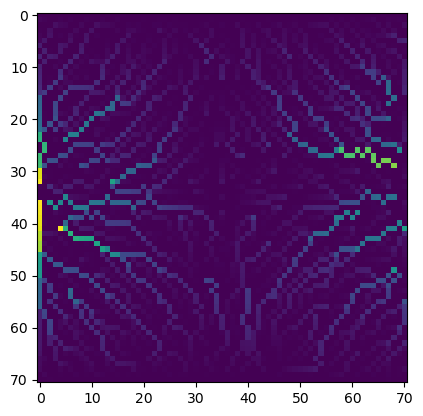

In [29]:
with rasterio.open(r"C:\Users\sasha\abstract_surfaces\surfaces\clear\paraboloid_clear.tif", 'r') as ds:
    data_clear = ds.read()
    data_clear = data_clear[0]
    
with rasterio.open(r"C:\Users\sasha\abstract_surfaces\surfaces\noisy\paraboloid_un_1.tif", 'r') as ds:
    data_noisy = ds.read()
    data_noisy = data_noisy[0]

with rasterio.open(r'C:\Users\sasha\abstract_surfaces\surfaces\filtered\paraboloid_un_1_filt.tif', 'r') as ds:
    data_filt = ds.read()
    data_filt = data_filt[0]

# with rasterio.open(r"C:\Users\sasha\abstract_surfaces\surfaces\morpho\paraboloid_un_1_slope.tif", 'r') as ds:
#     data_morpho_c = ds.read()
#     data_morpho_c = data_morpho_c[0]

# with rasterio.open(r"C:\Users\sasha\abstract_surfaces\surfaces\morpho\paraboloid_un_1_slope.tif", 'r') as ds:
#     data_morpho_c = ds.read()
#     data_morpho_c = data_morpho_c[0]
# ---
# ---
# ---
with rasterio.open(r"C:\Users\sasha\abstract_surfaces\surfaces\morpho\paraboloid_clear_d8.tif", 'r') as ds:
    data_morpho_c = ds.read()
    data_morpho_c = data_morpho_c[0]

with rasterio.open(r"C:\Users\sasha\abstract_surfaces\surfaces\morpho\paraboloid_un_1_d8.tif", 'r') as ds:
    data_morpho_n = ds.read()
    data_morpho_n = data_morpho_n[0]

with rasterio.open(r"C:\Users\sasha\abstract_surfaces\surfaces\morpho\paraboloid_un_1_filt_d8_acc.tif", 'r') as ds:
    data_morpho_f = ds.read()
    data_morpho_f = data_morpho_f[0]

with rasterio.open(r"C:\Users\sasha\abstract_surfaces\surfaces\morpho\paraboloid_clear_d8_acc.tif", 'r') as ds:
    data_morpho_с = ds.read()
    data_morpho_с = data_morpho_с[0]

# paraboloid_n_2.tif

plt.imshow(data_morpho_f)

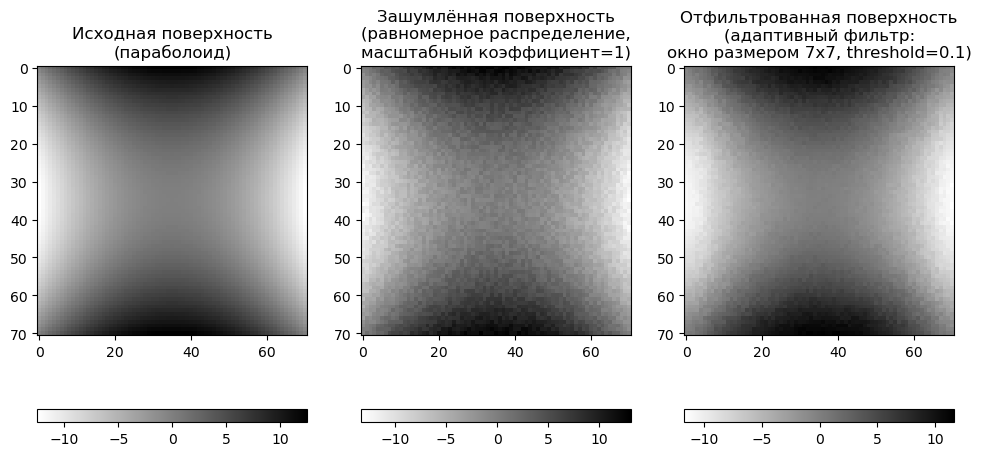

In [32]:
#Vis
fig = plt.figure(figsize=(16, 14))

ax1 = fig.add_subplot(2, 4, 1)
ax1.set_title('Исходная поверхность\n(параболоид)')
plt.imshow(data_clear, cmap='binary')
plt.colorbar(fraction=0.045, orientation='horizontal')

ax2 = fig.add_subplot(2, 4, 2)
ax2.set_title('Зашумлённая поверхность\n(равномерное распределение,\nмасштабный коэффициент=1)')
plt.imshow(data_noisy, cmap='binary')
plt.colorbar(fraction=0.045, orientation='horizontal')

ax3 = fig.add_subplot(2, 4, 3)
ax3.set_title('Отфильтрованная поверхность\n(адаптивный фильтр:\nокно размером 7x7, threshold=0.1)')
plt.imshow(data_filt, cmap='binary')
plt.colorbar(fraction=0.045, orientation='horizontal')

plt.savefig(r"C:\Users\sasha\abstract_surfaces\surfaces\res.png")